Benchmark of 4 feature selection techniques: HSIC Lasso, Block HSIC Lasso, mRMR and CV LASSO. For different combinations we generated synthetic data of varying numbers of samples (100, 1000, 10000) and numbers of features (1000, 2500, 5000, 10000). Applying the above methods, we tried to recover the original causal features. For each experimental condition, we generated 10 replicates. For each of the methods, the way to select features was different:

- LASSO can select as many features as it needs to reduce cross-validated training error.
- mRMR is asked to select the best 4 features.
- (Block) HSIC Lasso is asked to select 50 features. All 50 are used for the regression, but only the top 4 are considered for feature selection evaluation.

In [1]:
library(tidyverse)
library(cowplot)

palette <- c('HSIC Lasso' = '#c994c7', 'HSIC Lasso, B = 50' = '#df65b0',
             'HSIC Lasso, B = 40' = '#e7298a', 'HSIC Lasso, B = 30' = '#ce1256',
             'HSIC Lasso, B = 20' = '#980043', 'HSIC Lasso, B = 10' = '#67001f',
             'LassoCV' = '#2171b5', 'mRMR' = '#238443')
methods <- c('HSIC Lasso', 'HSIC Lasso, B = 50',
             'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
             'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
             'mRMR', 'LassoCV')
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# Feature selection

In [2]:
features <- read_tsv('../results/benchmark/feature_selection.tsv', col_types = 'ciiiiid') %>%
    mutate(model = gsub('hsic_lasso', 'HSIC Lasso', model),
           model = gsub('-b', ', B = ', model),
           model = factor(model, levels = methods)) %>%
    group_by(model, samples, features) %>%
    summarize(ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr)) %>%
    ungroup

Warning message:
“Removed 10 rows containing missing values (geom_errorbar).”Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 7 rows containing missing values (geom_path).”

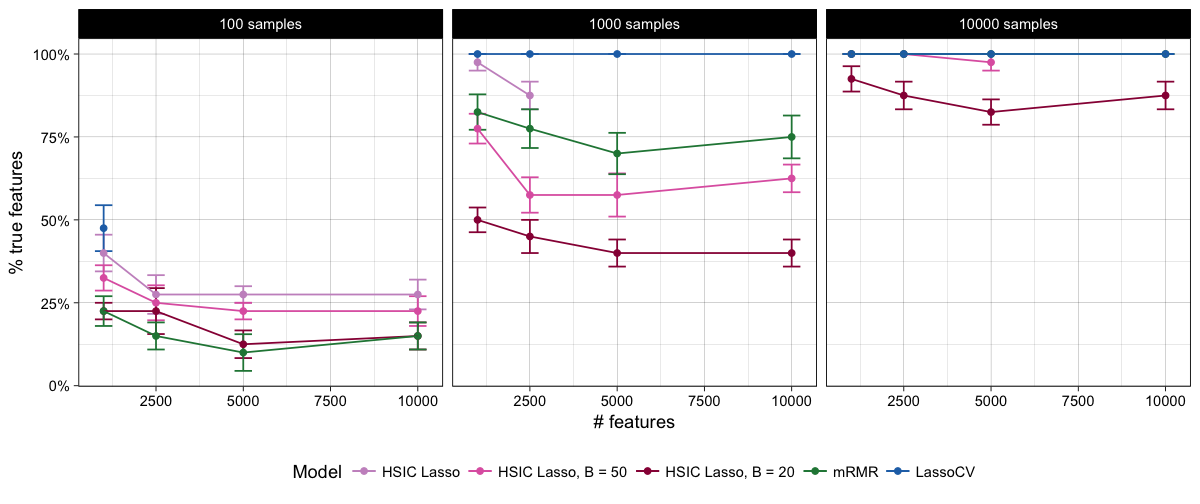

In [3]:
options(repr.plot.width=10, repr.plot.height=4.2)
features %>%
    mutate(n = paste(samples, 'samples')) %>%
    ggplot(aes(x = features, y = tpr, color = model)) +
        geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom') +
        labs(x = '# features', y = '% true features', color = 'Model') +
        facet_grid(. ~ n, scales = 'free') + 
        scale_y_continuous(labels = scales::percent) +
        scale_color_manual(values = palette)

Vanilla HSIC Lasso outperforms mRMR in all the settings where is can run. However, it stops working at ~ samples > 1000. Regarding the block versions, they perform worse than mRMR in most settings, specially for smaller block sizes. However, it is not clear if these are the best experimental settings for block HSIC lasso i.e. pick 50 features but use only the top 4.

Lasso seems to select most of the features.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


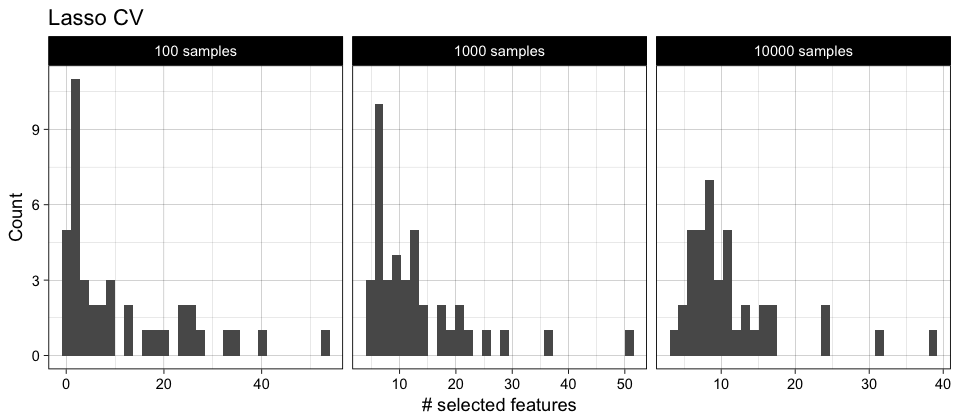

In [4]:
options(repr.plot.width=8, repr.plot.height=3.5)
read_tsv('../results/benchmark/feature_selection.tsv', col_types = 'ciiiiid') %>%
    filter(model == 'LassoCV') %>%
    mutate(n = paste(samples, 'samples')) %>%
    ggplot(aes(selected)) +
        geom_histogram() +
        theme_linedraw() +
        facet_grid(. ~ n, scales = 'free') +
        labs(x = '# selected features', y = 'Count', title = 'Lasso CV')

However, it does so by selecting a large number of features, some of them being the true features.

Warning message:
“Removed 10 rows containing missing values (geom_errorbar).”Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_path).”

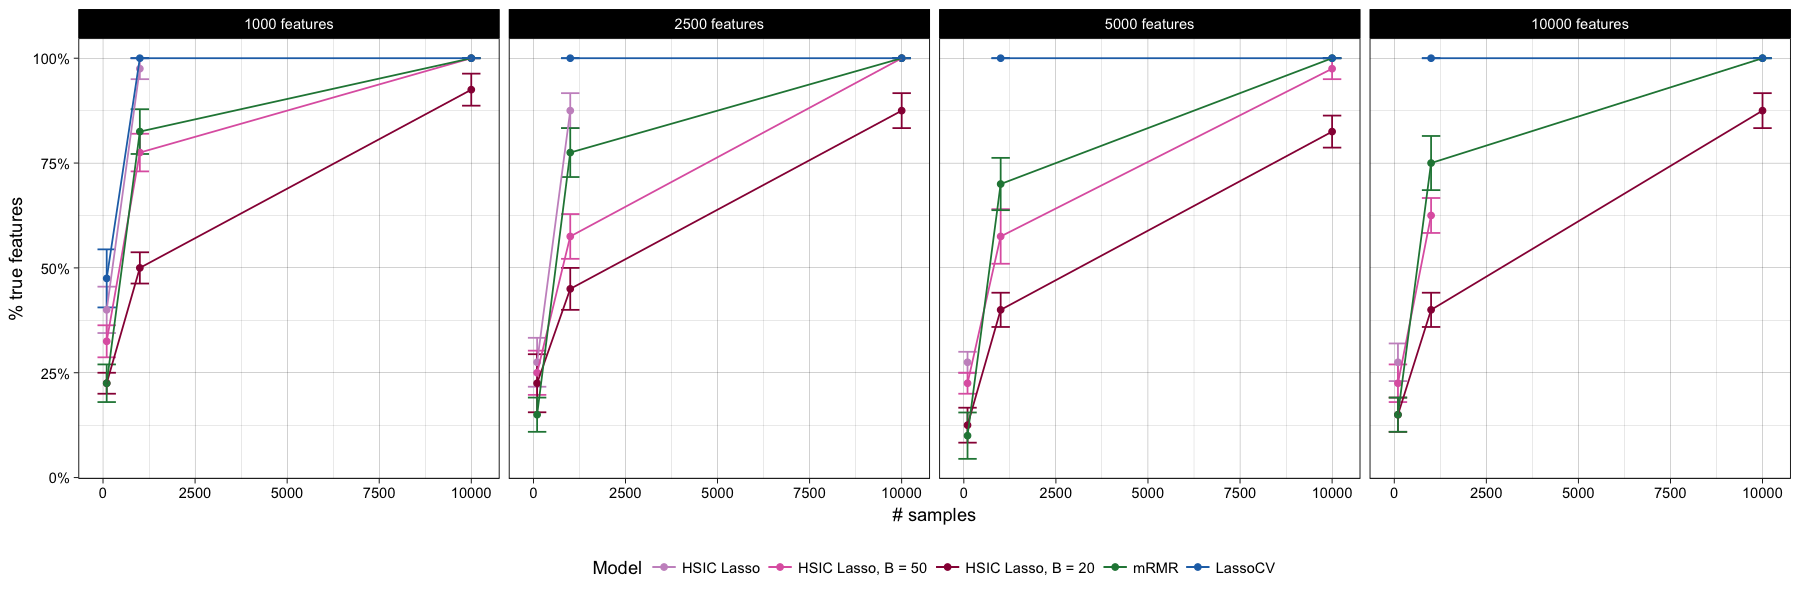

In [5]:
options(repr.plot.width=15, repr.plot.height=5)
features %>%
    mutate(d = factor(paste(features, 'features'), levels = feats)) %>%
    ggplot(aes(x = samples, y = tpr, color = model)) +
        geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom') +
        labs(x = '# samples', y = '% true features', color = 'Model') +
        facet_grid(. ~ d, scales = 'free') + 
        scale_y_continuous(labels = scales::percent) +
        scale_color_manual(values = palette)

The conclusions are the same if we stratify by the number of features.

# Computational feasibility

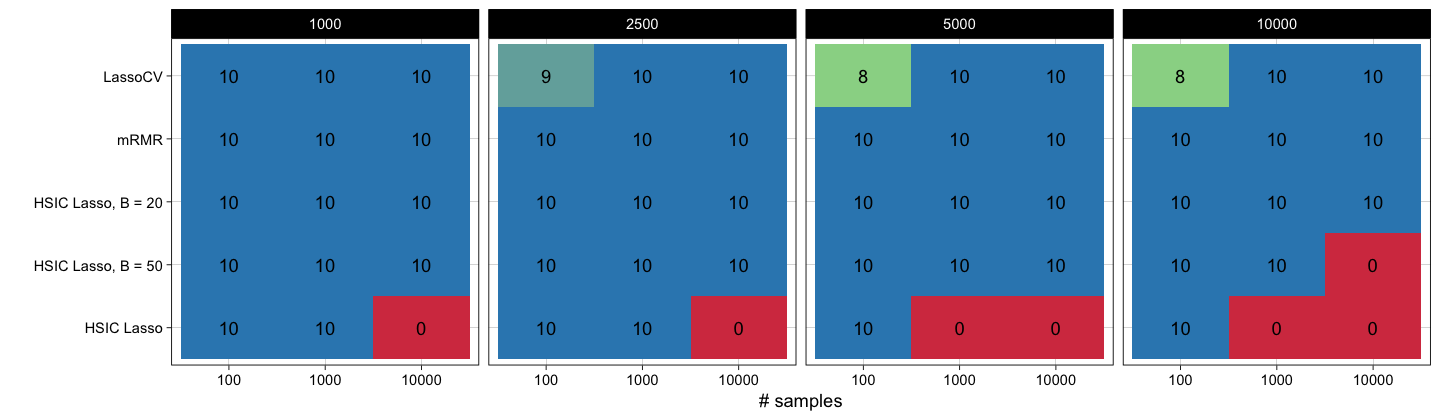

In [6]:
options(repr.plot.width=12, repr.plot.height=3.5)
features %>%
    group_by(model, samples, features) %>%
    summarize(ended = sum(ended)) %>%
    ggplot(aes(x = as.character(samples), y = model, fill = ended, label = ended)) +
        geom_tile() +
        geom_text() +
        theme_linedraw() +
        facet_grid(. ~ features) +
        theme(legend.position = 'none') +
        labs(x = '# samples', y = '') + 
        scale_fill_distiller(palette = "Spectral", direction = 1)

Computational resources were not tightly controlled, but we placed a a hard limit of 50GBs on memory consumption. When that memory was exceeded, jobs were killed. Above plot shows which jobs went over the limit. By using blocks, we are able to keep running HSIC Lasso in high dimensions.

# Prediction accuracy

We fitted a kernelized SVR to the features selected by mRMR and HSIC lasso. Then we measured the accuracy of the prediction as R<sup>2</sup> w.r.t. the output vector.

In [7]:
prediction <- read_tsv('../results/benchmark/prediction.tsv', col_types = 'ciiiiid') %>%
    mutate(model = gsub('hsic_lasso', 'HSIC Lasso', model),
           model = gsub('-b', ', B = ', model)) %>%
    group_by(model, samples, features) %>%
    summarize(ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup

Warning message:
“Removed 7 rows containing missing values (geom_errorbar).”Warning message:
“Removed 7 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_path).”

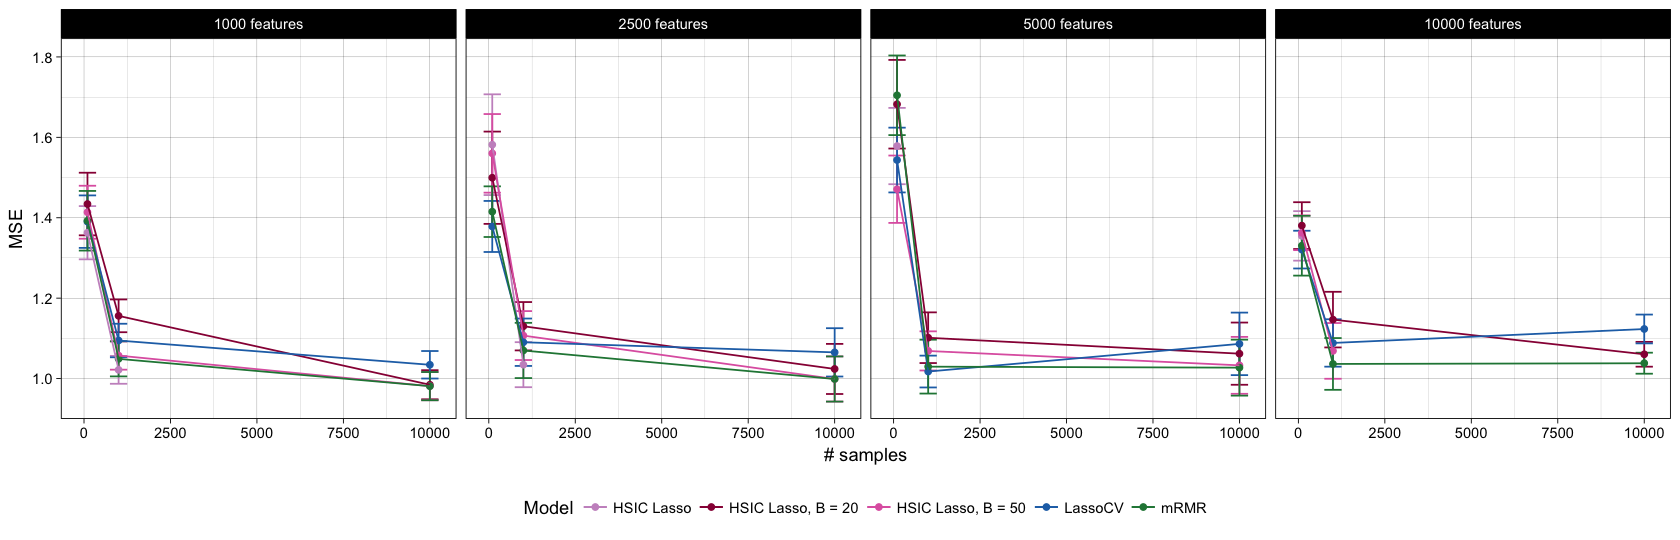

In [8]:
options(repr.plot.width=14, repr.plot.height=4.5)
prediction %>%
    mutate(d = factor(paste(features, 'features'), levels = feats)) %>%
    ggplot(aes(x = samples, y = mse, color = model)) +
        geom_errorbar(aes(ymin = mse - sem, ymax = mse + sem), width = 500) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom') +
        labs(x = '# samples', y = 'MSE', color = 'Model') +
        facet_grid(. ~ d) +
        scale_color_manual(values = palette)

If we look at the accuracy of the classifier, all versions of HSIC Lasso remain very competitive with mRMR. This means that out of the 50 features, HSIC lasso is selecting all the true features. Interestingly, Lasso is very competitive as well, meaning that the behavior of the features can be well approximated by a line.

Warning message:
“Removed 7 rows containing missing values (geom_errorbar).”Warning message:
“Removed 7 rows containing missing values (geom_point).”Warning message:
“Removed 7 rows containing missing values (geom_path).”

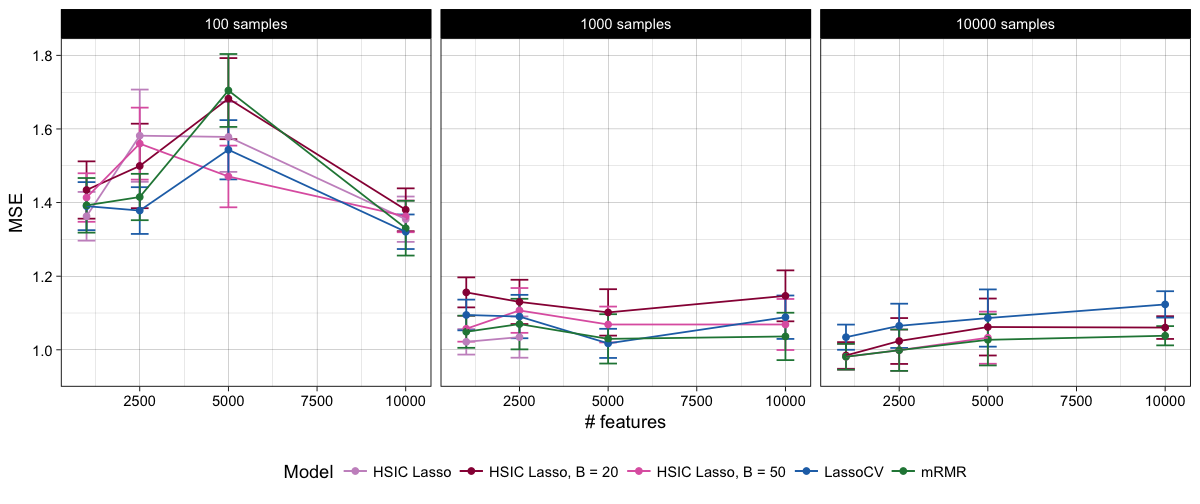

In [9]:
options(repr.plot.width=10, repr.plot.height=4.2)
prediction %>%
    mutate(n = paste(samples, 'samples')) %>%
    ggplot(aes(x = features, y = mse, color = model)) +
        geom_errorbar(aes(ymin = mse - sem, ymax = mse + sem), width = 500) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom') +
        labs(x = '# features', y = 'MSE', color = 'Model') +
        facet_grid(. ~ n) +
        scale_color_manual(values = palette)

Idem.